# 1) Install Requirements

In [1]:
# numpy pandas matplotlib scikit-learn torch torchvision torchaudio torchinfo watermark

# 2) Import Dataset

In [2]:
!wget https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit04-multilayer-nets/4.3-mlp-pytorch/4.3-mlp-pytorch-part1-2-xor/xor.csv -O xor_dataset.csv

--2024-06-28 14:05:08--  https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit04-multilayer-nets/4.3-mlp-pytorch/4.3-mlp-pytorch-part1-2-xor/xor.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Lightning-AI/dl-fundamentals/main/unit04-multilayer-nets/4.3-mlp-pytorch/4.3-mlp-pytorch-part1-2-xor/xor.csv [following]
--2024-06-28 14:05:08--  https://raw.githubusercontent.com/Lightning-AI/dl-fundamentals/main/unit04-multilayer-nets/4.3-mlp-pytorch/4.3-mlp-pytorch-part1-2-xor/xor.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30601 (30K) [text/plain]
Saving to: ‘xor_dataset.csv’

xor_d

In [29]:
import pandas as pd
df = pd.read_csv("xor_dataset.csv")
df

,x1,x2,class label
0,0.781306,1.062984,0
1,-1.060524,-1.095550,0
2,0.632125,0.674028,0
3,-1.424712,0.535203,1
4,1.383161,1.368510,0
...,...,...,...
745,0.792484,0.839275,0
746,0.582466,-0.749250,1
747,-1.593475,0.671721,1
748,-0.812671,-0.268542,0


In [30]:
X = df[['x1', 'x2']].values
y = df['class label'].values

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y
)

X_train, X_val, y_train, y_eval = train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)

In [32]:
print(f"Train Size: {X_train.shape}")
print(f"Val Size: {X_val.shape}")
print(f"Test Size: {X_test.shape}")

Train Size: (573, 2)
Val Size: (64, 2)
Test Size: (113, 2)


In [33]:
import numpy as np

print(f"Train Labels: {np.bincount(y_train)}")
print(f"Val Labels: {np.bincount(y_eval)}")
print(f"Test Labels: {np.bincount(y_test)}")

Train Labels: [287 286]
Val Labels: [32 32]
Test Labels: [57 56]


# 3) Visualization

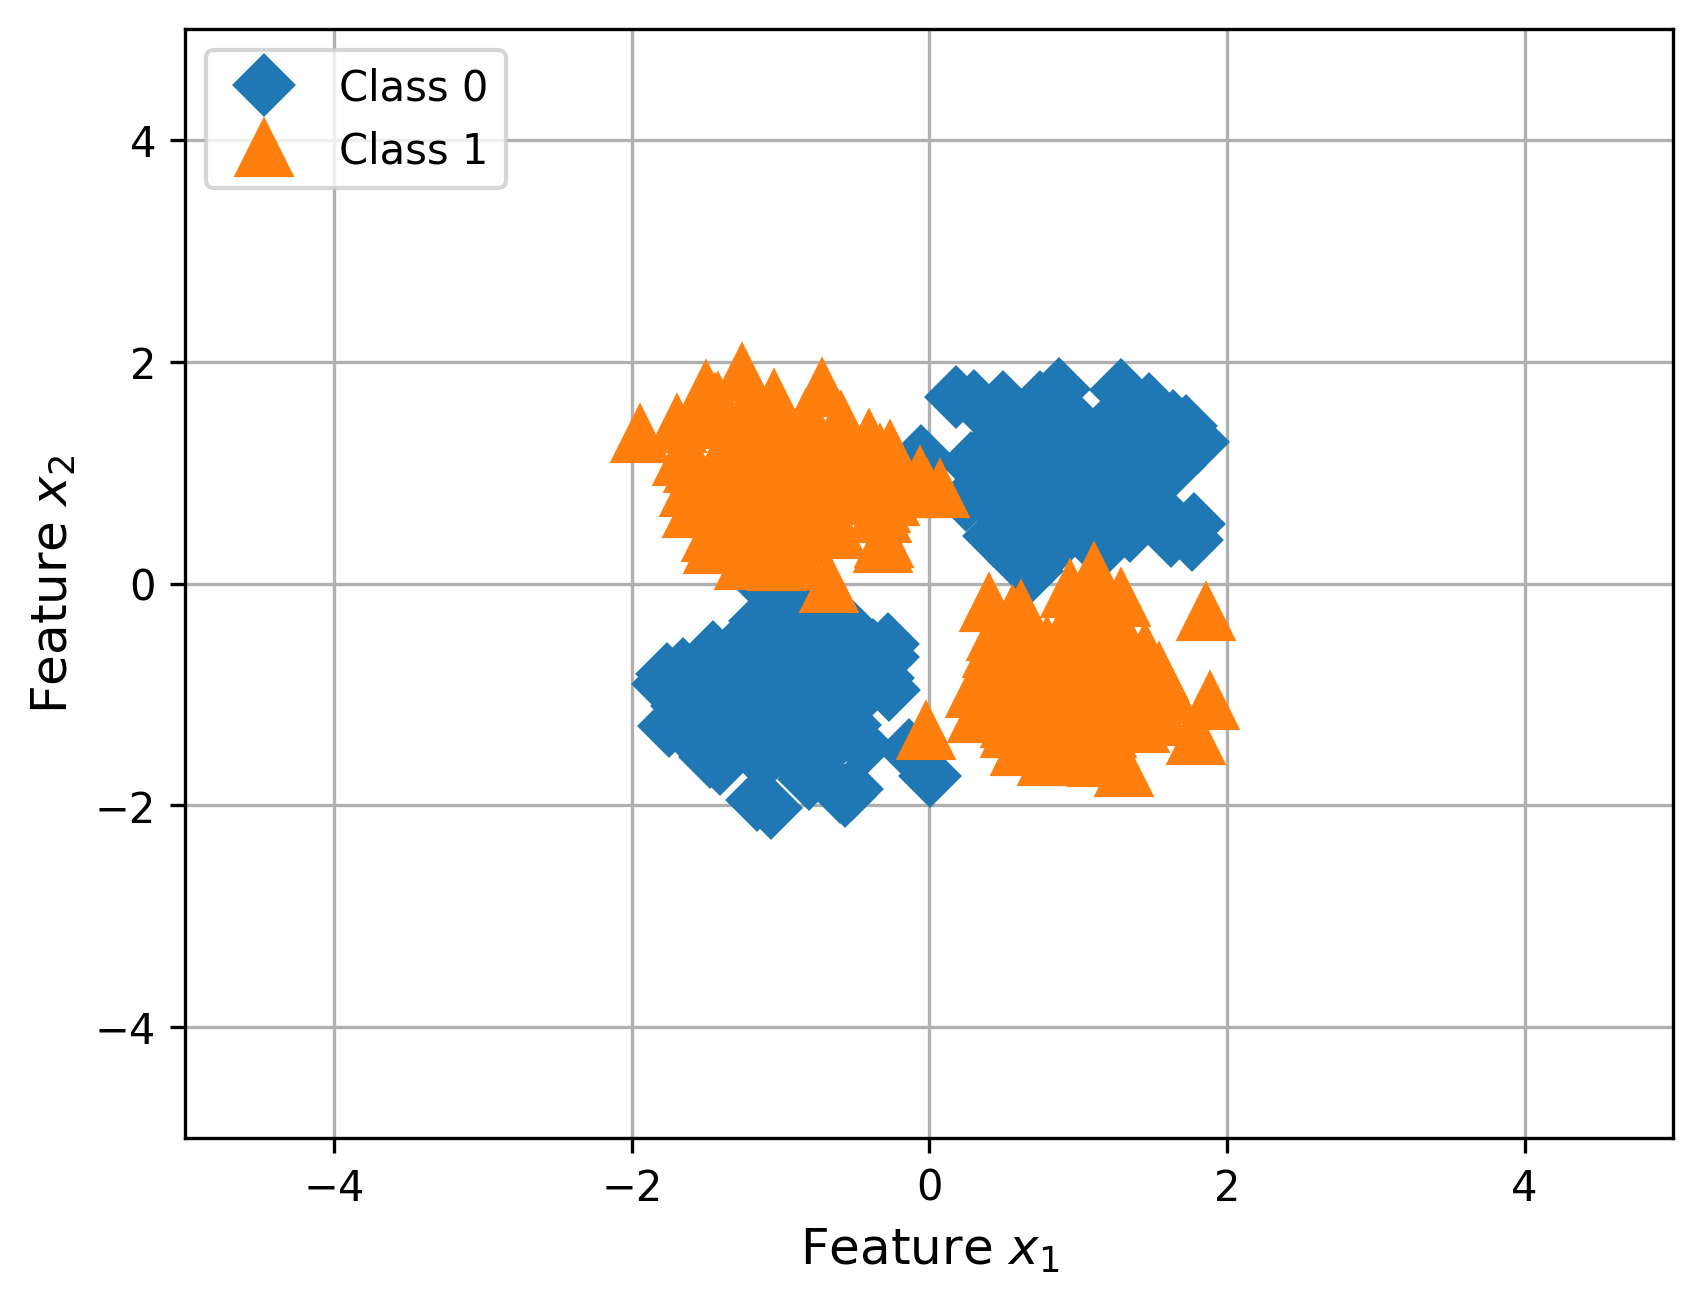

In [34]:
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 300

plt.plot(
    X_train[y_train == 0, 0],
    X_train[y_train == 0, 1],
    marker="D",
    markersize=10,
    linestyle="",
    label="Class 0",
)

plt.plot(
    X_train[y_train == 1, 0],
    X_train[y_train == 1, 1],
    marker="^",
    markersize=13,
    linestyle="",
    label="Class 1",
)

plt.legend(loc=2)

plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel("Feature $x_1$", fontsize=12)
plt.ylabel("Feature $x_2$", fontsize=12)


plt.grid()
plt.show()

# 4) Implementing the Model

In [35]:
import torch

class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(num_features, 25), # 1st Hidden Layer
            torch.nn.ReLU(),

            torch.nn.Linear(25, 15), # 2nd Hidden Layer
            torch.nn.ReLU(),

            torch.nn.Linear(15, num_classes), # Output Layer
        )

    def forward(self, features):
        logits = self.layers(features)
        return logits

# 5) Dataloaders

In [36]:
from torch.utils.data import Dataset, DataLoader

class MLPDataSet(Dataset):
    def __init__(self, X, y):
        self.features = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(y, dtype=torch.int64)

    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]

        return x, y

    def __len__(self):
        return self.labels.shape[0]

train_dataset = MLPDataSet(X_train, y_train)
val_dataset = MLPDataSet(X_val, y_eval)
test_dataset = MLPDataSet(X_test, y_test)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
)

# 6) Training Loop

In [37]:
def compute_accuracy(model, dataloader):
    model.eval()

    correct = 0.0
    total = 0.0

    for idx, (features, labels) in enumerate(dataloader):
        with torch.inference_mode():
            logits = model(features)

        predictions = torch.argmax(logits, dim=1)

        compare = labels == predictions
        correct += torch.sum(compare)
        total += len(compare)

    return correct / total

In [64]:
import torch.nn.functional as F

model = MultiLayerPerceptron(num_features=2, num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05) # Stochastic Gradient Descent

num_epochs = 15
for epoch in range(num_epochs):
    model = model.train()
    for idx, (features, labels) in enumerate(train_dataloader):
        logits = model(features)
        loss = F.cross_entropy(logits, labels) # Loss Function

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ### LOGGING
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {idx:03d}/{len(train_dataloader):03d}"
              f" | Train/Val Loss: {loss:.2f}")

    train_acc = compute_accuracy(model, train_dataloader)
    val_acc = compute_accuracy(model, val_dataloader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

Epoch: 001/015 | Batch 000/018 | Train/Val Loss: 0.66
Epoch: 001/015 | Batch 001/018 | Train/Val Loss: 0.69
Epoch: 001/015 | Batch 002/018 | Train/Val Loss: 0.68
Epoch: 001/015 | Batch 003/018 | Train/Val Loss: 0.70
Epoch: 001/015 | Batch 004/018 | Train/Val Loss: 0.67
Epoch: 001/015 | Batch 005/018 | Train/Val Loss: 0.69
Epoch: 001/015 | Batch 006/018 | Train/Val Loss: 0.67
Epoch: 001/015 | Batch 007/018 | Train/Val Loss: 0.68
Epoch: 001/015 | Batch 008/018 | Train/Val Loss: 0.69
Epoch: 001/015 | Batch 009/018 | Train/Val Loss: 0.65
Epoch: 001/015 | Batch 010/018 | Train/Val Loss: 0.67
Epoch: 001/015 | Batch 011/018 | Train/Val Loss: 0.66
Epoch: 001/015 | Batch 012/018 | Train/Val Loss: 0.67
Epoch: 001/015 | Batch 013/018 | Train/Val Loss: 0.66
Epoch: 001/015 | Batch 014/018 | Train/Val Loss: 0.66
Epoch: 001/015 | Batch 015/018 | Train/Val Loss: 0.66
Epoch: 001/015 | Batch 016/018 | Train/Val Loss: 0.65
Epoch: 001/015 | Batch 017/018 | Train/Val Loss: 0.64
Train Acc 77.14% | Val Acc 7

# 7) Evaluating Performance

In [65]:
print(f"Train Accuracy: {compute_accuracy(model, train_dataloader)*100:.2f}%")
print(f"Val Accuracy: {compute_accuracy(model, val_dataloader)*100:.2f}%")
print(f"Test Accuracy: {compute_accuracy(model, test_dataloader)*100:.2f}%")

Train Accuracy: 99.13%
Val Accuracy: 100.00%
Test Accuracy: 97.35%


# 8) Visualizing Decision Boundary

In [66]:
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('D', '^', 'x', 's', 'v')
    colors = ('C0', 'C1', 'C2', 'C3', 'C4')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    logits = classifier.forward(tensor)
    Z = np.argmax(logits.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    #edgecolor='black',
                    marker=markers[idx],
                    label=cl)

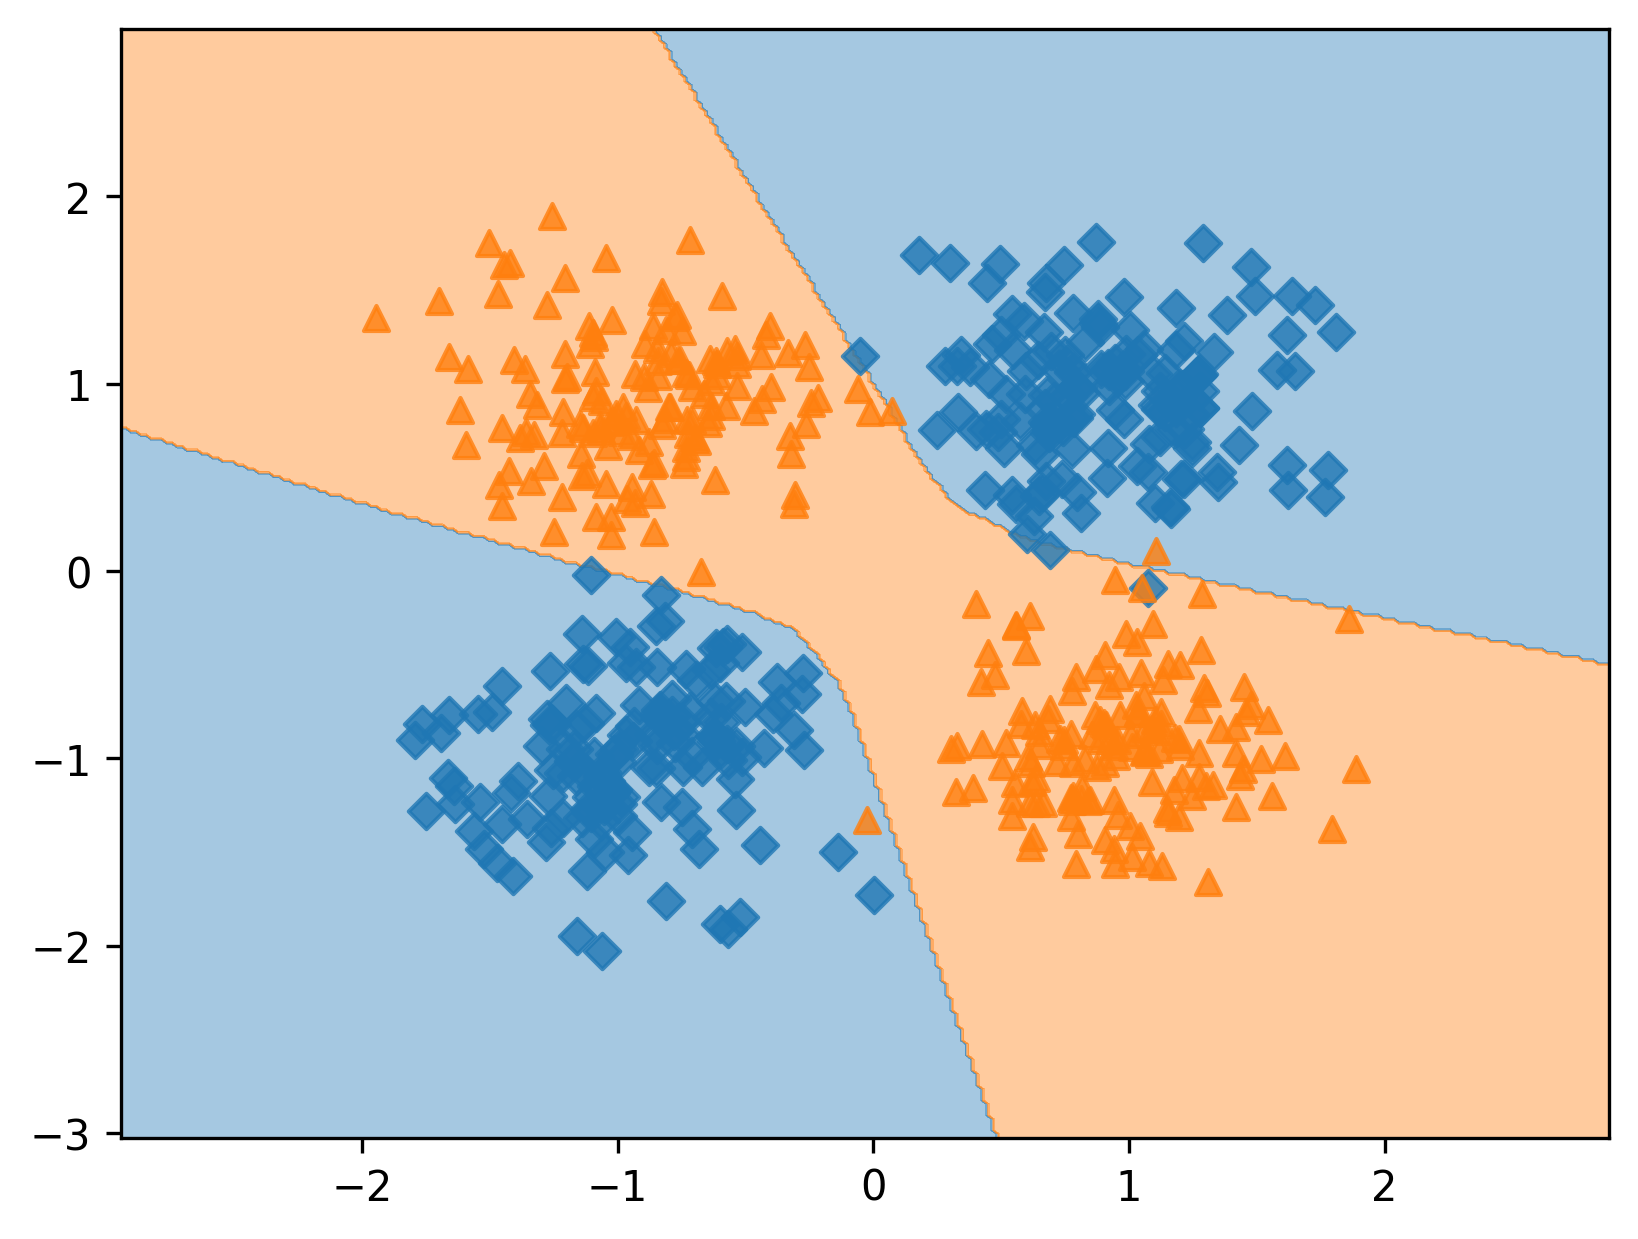

In [67]:
plot_decision_regions(X_train, y_train, classifier=model)